# Introduction
Going to be using multi-classifier fusion to predict COVID-19 fatalities and confirmed cases

# Algorithm:
- 1) Process data
  - a) Process in inputs X and labels Y for train data 
    - i) Leave some data for validation set 
  - b) Process in inputs X for test data 
- 2) Build model
  - a) Train model using gradient boost regressor 
  - b) Train model using random forest regressor
  - c) If the root mean square error (RMSE) is significant for either model, create multi-classifier fusion
    - i) Using geometric mean between two outputs from two models
- 3) Display outputs

# Import modules/dependencies 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import math

/home/niklaus/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Processing Train, Validation, and Test data

In [2]:
# Import from .csv files
trainData = pd.read_csv("train.csv") 
testData = pd.read_csv("test.csv") 

# Create pandas dataFrames from .csv's 
trainData = pd.DataFrame(trainData) 
testData = pd.DataFrame(testData) 

# There are some empty cells in the .csv's. Fill those with 0's 
trainData.fillna("0", inplace = True) 
testData.fillna("0", inplace = True) 

## Tokenize words as numbers for the models

### Word to number function

In [3]:
class wordToNumber:
    """
    Index each word as a number, then return that list of words->numbers
    - "data" input is the column list from train or test data 
    """
    def returnWordToNumberList(self, data, word_to_index): 
        """
        - Return the converted list
        - Return the word_to_index to the same is used in train and test dat 
        """
        index = 1 
        returnedList = [] 
        for word in data: 
            if word in word_to_index: 
                returnedList.append(word_to_index[word]) 
            else: 
                word_to_index[word] = index 
                returnedList.append(index) 
                index += 1
        return returnedList, word_to_index

### Use word to number function for train and test data

In [4]:
# Columns to be tokenized. Also including Date because dates show up multiple times
tokenizeColumns = [
    "Province_State", 
    "Country_Region", 
    "Date", 
]

# Algorithm 
for column in tokenizeColumns:
    word_to_index = {} # Empty at the start of each column
    trainData[column], word_to_index = wordToNumber().returnWordToNumberList(
        data = trainData[column], 
        word_to_index = word_to_index,  # empty one ({})
    ) 
    testData[column], word_to_index = wordToNumber().returnWordToNumberList(
        data = testData[column],
        word_to_index = word_to_index,  # Same used from trainData
    ) 

### Set the index for each set

In [5]:
trainData = trainData.set_index("Id") 
testData = testData.set_index("ForecastId") 

## Split in to inputs X and labels Y

In [6]:
# Define Y label columns
Y_columns = [
    "ConfirmedCases",
    "Fatalities",
]

# Split in to X and Y for train/validation sets
trainX, trainY = {}, {} 
for column in trainData.columns:
    if column in Y_columns:
        trainY[column] = trainData[column] 
    else:
        trainX[column] = trainData[column] 
        
# Make pandas data frames
trainX, trainY = pd.DataFrame(trainX), pd.DataFrame(trainY)

## Split train data in to train and validation set

In [7]:
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size = 0.2) 

# Modeling

## Gradient Boost Regressor Modeling (XGBR)

In [8]:
# Need to use a dictionary for fitting
xgb_fit_graph = {
    "ConfirmedCases" : 0,
    "Fatalities" : 0,
}
for label in xgb_fit_graph:
    xgb = XGBRegressor(n_classifiers = 1000)
    xgb_fit_graph[label] = xgb.fit(trainX, trainY[label]) 

# Also use a dictionary for predictions
xgb_predictions = {}
for label in xgb_fit_graph:
    xgb_predictions[label + "Train"] = xgb_fit_graph[label].predict(trainX)
    xgb_predictions[label + "Validation"] = xgb_fit_graph[label].predict(validationX)
    

/home/niklaus/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/niklaus/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/niklaus/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/niklaus/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Random Forest Regressor

In [9]:
RF_fit_graph = {
    "ConfirmedCases" : 0,
    "Fatalities" : 0,
}
for label in RF_fit_graph:
    RF = RandomForestClassifier()
    RF.fit(trainX, trainY[label]) 
    RF_fit_graph[label] = RF 
    
# Dictionary for predictions
RF_predictions = {}
for label in RF_fit_graph:
    RF_predictions[label + "Train"] = RF_fit_graph[label].predict(trainX) 
    RF_predictions[label + "Validation"] = RF_fit_graph[label].predict(validationX) 

## Fusion Classifier 

Going to be using Geometric Mean to fuse outputs from both regressors together. That way, hopefully where one fails, the fusion can make up for it

### Geometric Mean Function

In [10]:
def geometricMean(values):
    """
    Found this equation from https://en.wikipedia.org/wiki/Geometric_mean
    """
    multipliedVal = 1 
    for element in values:
        multipliedVal *= element 
    
    N = len(values) 
    
    try:  # Sometimes error with values/doesn't like inputs
        multipliedVal = (multipliedVal) ** (1 / N) 
        if math.isnan(multipliedVal) is True: 
            multipliedVal = 0 
    except: 
        multipliedVal = 0 
        
    return multipliedVal

In [11]:
# Start with empty graph 
fusion_predictions = {}

# Define which fitGraphs are for what
fitGraphs = {
    "xgb" : xgb_fit_graph, 
    "RF" : RF_fit_graph,
}

# Define which regressors to be analyzed for their RMSEs 
regressorGraph = {
    "xgb" : xgb_predictions, 
    "RF" : RF_predictions,
}

# Types of sets 
setTypes = {
    "Train" : trainY, 
    "Validation" : validationY, 
}

# Fusion algorithm 
for label in xgb_fit_graph: 
    for setType in setTypes:
        temporaryArray = [] 
        for k, element in enumerate(regressorGraph["xgb"][label + setType]):
            values = [] 
            for regressor in regressorGraph:
                value = regressorGraph[regressor][label + setType][k] 
                values.append(value) 
            temporaryArray.append(geometricMean(values))
            
        fusion_predictions[label + setType] = temporaryArray

# Update regressorGraph
regressorGraph["Fusion"] = fusion_predictions
    

/home/niklaus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


# Seeing how models did

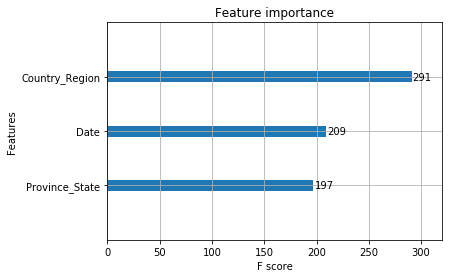

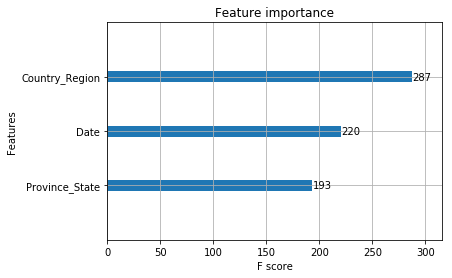

In [12]:
# Let's see how important variables are using gradient boost module
for label in xgb_fit_graph:
    plot_importance(xgb_fit_graph[label]) 
    plt.show()

## Seeing how train and validation predictions went 

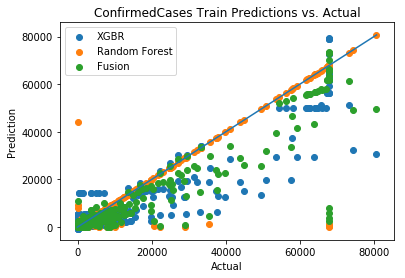

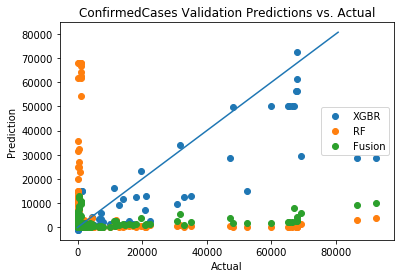

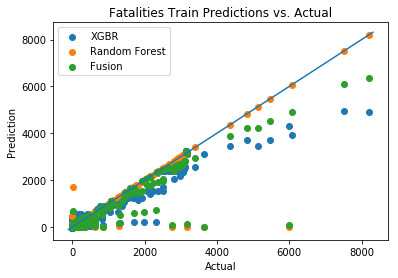

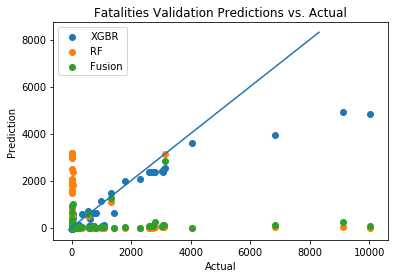

In [13]:
for label in xgb_fit_graph:
    plt.figure(1)
    xlin = np.arange(min(trainY[label]) - 100, max(trainY[label]) + 100)
    plt.scatter(trainY[label], xgb_predictions[label+"Train"], label = "XGBR") 
    plt.scatter(trainY[label], RF_predictions[label+"Train"], label = "Random Forest")
    plt.scatter(trainY[label], fusion_predictions[label+"Train"], label = "Fusion")
    plt.plot(xlin, xlin) 
    plt.legend()
    plt.xlabel("Actual") 
    plt.ylabel("Prediction") 
    plt.title(label + " Train Predictions vs. Actual") 
    plt.show()
    
    plt.figure(2)
    xlin = np.arange(min(trainY[label]) - 100, max(trainY[label]) + 100)
    plt.scatter(validationY[label], xgb_predictions[label+"Validation"], label = "XGBR") 
    plt.scatter(validationY[label], RF_predictions[label+"Validation"], label = "RF")
    plt.scatter(validationY[label], fusion_predictions[label+"Validation"], label = "Fusion")
    plt.plot(xlin, xlin) 
    plt.legend()
    plt.xlabel("Actual") 
    plt.ylabel("Prediction") 
    plt.title(label + " Validation Predictions vs. Actual") 
    plt.show()

## Calculate RMSE values for each

### RMSE equation

In [14]:
def RMSE(data1, data2):
    return mean_squared_error(data1, data2) ** (1/2)

### Do RMSE for each train and validation prediction

In [15]:
# Start with empty graph
RMSEs = {} 

# Iterate through train and validation labels and update RMSE dictionary
for label in xgb_fit_graph: # Defined a few boxes above
    for regressor in regressorGraph: # also defined a few boxes above
        for setType in setTypes: # also defined a few boxes above
            RMSEs[label + regressor + setType] = RMSE(setTypes[setType][label], regressorGraph[regressor][label + setType])
    
# Print each RMSE
for label in RMSEs:
    print(label + " RMSE: %0.3f"%RMSEs[label])

ConfirmedCasesxgbTrain RMSE: 1467.785
ConfirmedCasesxgbValidation RMSE: 2078.394
ConfirmedCasesRFTrain RMSE: 1227.715
ConfirmedCasesRFValidation RMSE: 5698.277
ConfirmedCasesFusionTrain RMSE: 1376.508
ConfirmedCasesFusionValidation RMSE: 4152.192
FatalitiesxgbTrain RMSE: 67.949
FatalitiesxgbValidation RMSE: 126.183
FatalitiesRFTrain RMSE: 67.998
FatalitiesRFValidation RMSE: 322.603
FatalitiesFusionTrain RMSE: 75.564
FatalitiesFusionValidation RMSE: 281.926


# Conclusions

Random Forest seems to perform the best. Saving submissions.csv from there!

In [16]:
submissionsCSV = {} 

# Test Predictions - fusion 
testPredictions = {} 

# Iterate through labels, and predict test data 
for label in xgb_fit_graph:
    tempGraph = {}
    for regressor in regressorGraph:
        if "Fusion" != regressor:
            tempGraph[regressor] = fitGraphs[regressor][label].predict(testData)

    testPredictions[label] = tempGraph

    predictions = []

    for k, element in enumerate(testPredictions[label]["xgb"]):
        values = []
        for regressor in regressorGraph:
            if "Fusion" != regressor:
                values.append(testPredictions[label][regressor][k]) 
        predictions.append(geometricMean(values))
    submissionsCSV[label] = predictions
    N = len(submissionsCSV[label])  # quick dirty solution to set forecastID, sorry
    
# Index 
submissionsCSV["ForecastId"] = np.arange(1, N+1) 
# print(submissionsCSV["ForecastId"][-1])

# Make data frame 
submissionsCSV = pd.DataFrame(submissionsCSV) 
# submissionsCSV = submissionsCSV.set_index("ForecastId")

# Save data frame to submissions.csv 
submissionsCSV.to_csv("submission.csv", index = False)

/home/niklaus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


12642
